# Config


In [ ]:
from shapely import wkb
from shapely import from_wkb

import geopandas as gpd
import duckdb
import duckdb
import geopandas as gpd


## extracting overture data using the API

In [ ]:

duckdb.install_extension('httpfs')
duckdb.load_extension('httpfs')

duckdb.sql("""
SET s3_region='us-west-2';
SET s3_access_key_id='';
SET s3_secret_access_key='';
SET s3_session_token='';
SET s3_url_style='path';
SET s3_use_ssl=true;
""")

# Try to read file names from the public Overture S3 bucket
df_files = duckdb.sql("""
SELECT DISTINCT filename
FROM read_parquet(
    's3://overturemaps-us-west-2/release/2025-10-22.0/theme=base/type=infrastructure/*.parquet',
    filename=true
)
LIMIT 10;
""").df()

print(df_files)


                                            filename
0  s3://overturemaps-us-west-2/release/2025-10-22...
1  s3://overturemaps-us-west-2/release/2025-10-22...
2  s3://overturemaps-us-west-2/release/2025-10-22...
3  s3://overturemaps-us-west-2/release/2025-10-22...
4  s3://overturemaps-us-west-2/release/2025-10-22...
5  s3://overturemaps-us-west-2/release/2025-10-22...
6  s3://overturemaps-us-west-2/release/2025-10-22...
7  s3://overturemaps-us-west-2/release/2025-10-22...
8  s3://overturemaps-us-west-2/release/2025-10-22...
9  s3://overturemaps-us-west-2/release/2025-10-22...


In [16]:


# 1️⃣ Connect + load extensions
duckdb.install_extension('httpfs')
duckdb.install_extension('spatial')
duckdb.load_extension('httpfs')
duckdb.load_extension('spatial')

# 2️⃣ S3 config
duckdb.sql("""
SET s3_region='us-west-2';
SET s3_url_style='path';
SET s3_use_ssl=true;
""")

# 3️⃣ Bounding box
xmin, ymin = 2.1506300913906213, 41.39176491606112
xmax, ymax = 2.175778482823838, 41.39491998407922
# xmin, ymin = 2.10, 41.35
# xmax, ymax = 2.25, 41.45
# 4️⃣ Query Overture "places"
query = f"""
SELECT
    basic_category AS category,
    ST_AsWKB(geometry) AS geometry
  FROM read_parquet(
  's3://overturemaps-us-west-2/release/2025-10-22.0/theme=places/type=place/*.parquet'
)
WHERE geometry IS NOT NULL
  AND ST_Intersects(
      ST_GeomFromText('POLYGON(({xmin} {ymin}, {xmax} {ymin}, {xmax} {ymax}, {xmin} {ymax}, {xmin} {ymin}))'),
      geometry
  )
LIMIT 1000;
"""




             category                  geometry
0    printing_service  POINT (2.17556 41.39178)
1          restaurant  POINT (2.17548 41.39219)
2  college_university  POINT (2.17545 41.39213)
3          psychology  POINT (2.17542 41.39275)
4          psychology  POINT (2.17535 41.39279)


<Axes: >

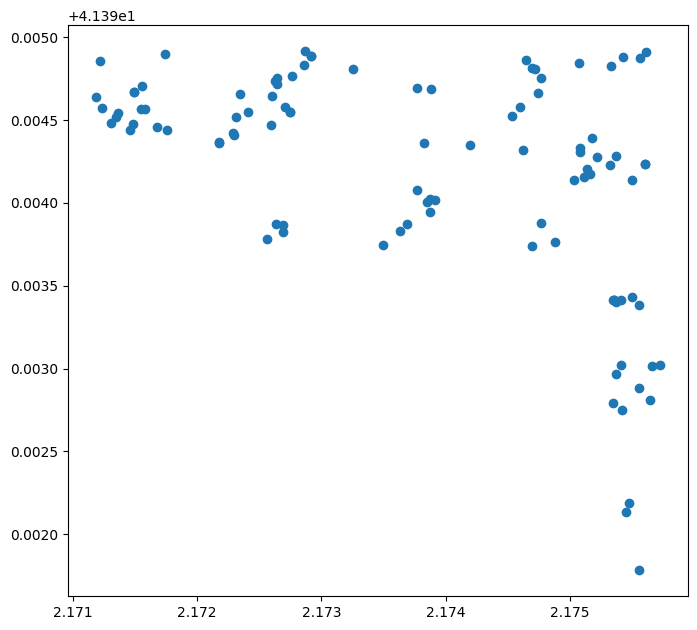

In [15]:
# 5️⃣ Read into Pandas DataFrame
df = duckdb.sql(query).df()

# 6️⃣ Convert WKB geometry to Shapely
df["geometry"] = df["geometry"].apply(lambda x: wkb.loads(bytes(x)) if isinstance(x, (bytes, bytearray)) else None)

# 7️⃣ Wrap in GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

# 8️⃣ Inspect and plot
print(gdf.head())
gdf.plot(figsize=(8,8))